<a href="https://colab.research.google.com/github/nadirawijaya/KomputasiIntelegensia/blob/main/EndTermTask_KI_Nadira_Putri_Wijaya_21096635190.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EndTerm Task
## Komputasi Intelegensia
### Nama: Nadira Putri Wijaya
### NPM: 2106635190

In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    auc
)

In [ ]:
# 2. DATA PREPROCESSING AND VISUALIZATION
class DataPreprocessor:
    def __init__(self, train_zip, test_zip, img_height=224, img_width=224, batch_size=32):
        """
        Initialize data preprocessor for medical image classification

        Args:
            train_zip (str): Path to training zip file
            test_zip (str): Path to test zip file
            img_height (int): Target image height
            img_width (int): Target image width
            batch_size (int): Batch size for data generators
        """
        self.train_zip = train_zip
        self.test_zip = test_zip

        # Create directories for extraction
        self.train_dir = '/content/train_dataset'
        self.test_dir = '/content/test_dataset'

        os.makedirs(self.train_dir, exist_ok=True)
        os.makedirs(self.test_dir, exist_ok=True)

        # Extract zip files
        self._extract_zip_files()

        self.img_height = img_height
        self.img_width = img_width
        self.batch_size = batch_size

        # Data generators
        self.train_generator = None
        self.validation_generator = None
        self.test_generator = None

    def _extract_zip_files(self):
        """Extract training and test zip files"""
        print("Extracting training dataset...")
        with zipfile.ZipFile(self.train_zip, 'r') as zip_ref:
            zip_ref.extractall(self.train_dir)

        print("Extracting test dataset...")
        with zipfile.ZipFile(self.test_zip, 'r') as zip_ref:
            zip_ref.extractall(self.test_dir)

        print("Datasets extracted successfully.")

    def prepare_data_generators(self):
        """Prepare data generators with augmentation"""
        # Data Augmentation
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            validation_split=0.2
        )

        test_datagen = ImageDataGenerator(rescale=1./255)

        # Train Generator
        self.train_generator = train_datagen.flow_from_directory(
            self.train_dir,
            target_size=(self.img_height, self.img_width),
            batch_size=self.batch_size,
            class_mode='categorical',
            subset='training'
        )

        # Validation Generator
        self.validation_generator = train_datagen.flow_from_directory(
            self.train_dir,
            target_size=(self.img_height, self.img_width),
            batch_size=self.batch_size,
            class_mode='categorical',
            subset='validation'
        )

        # Test Generator
        self.test_generator = test_datagen.flow_from_directory(
            self.test_dir,
            target_size=(self.img_height, self.img_width),
            batch_size=self.batch_size,
            class_mode='categorical',
            shuffle=False
        )

        return self.train_generator, self.validation_generator, self.test_generator

    def visualize_dataset(self):
        """Comprehensive dataset visualization"""
        # Visualize sample images
        plt.figure(figsize=(20, 10))

        # Training images
        plt.subplot(1, 2, 1)
        train_images, train_labels = next(self.train_generator)
        class_names = list(self.train_generator.class_indices.keys())

        for i in range(min(5, len(train_images))):
            plt.subplot(2, 5, i+1)
            plt.imshow(train_images[i])
            plt.title(f"Train: {class_names[np.argmax(train_labels[i])]}")
            plt.axis('off')

        # Test images
        plt.subplot(1, 2, 2)
        test_images, test_labels = next(self.test_generator)

        for i in range(min(5, len(test_images))):
            plt.subplot(2, 5, i+6)
            plt.imshow(test_images[i])
            plt.title(f"Test: {class_names[np.argmax(test_labels[i])]}")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Class distribution
        print("\n--- Class Distribution ---")
        for name, generator in [
            ("Training", self.train_generator),
            ("Validation", self.validation_generator),
            ("Test", self.test_generator)
        ]:
            print(f"\n{name} Dataset:")
            for cls, idx in generator.class_indices.items():
                count = sum(generator.classes == idx)
                print(f"{cls}: {count} images")

        # Visualize specific disease images
        self._visualize_disease_images(class_names)

    def _visualize_disease_images(self, class_names):
        """Visualize images for each disease class"""
        plt.figure(figsize=(20, 5))

        for i, disease in enumerate(class_names):
            # Find directory for this disease
            disease_dir = os.path.join(self.train_dir, disease)

            # Get list of image files
            image_files = [f for f in os.listdir(disease_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

            # Plot first 5 images for each disease
            for j in range(min(5, len(image_files))):
                plt.subplot(len(class_names), 5, i*5 + j + 1)
                img = plt.imread(os.path.join(disease_dir, image_files[j]))
                plt.imshow(img)
                plt.title(f"{disease}: {j+1}")
                plt.axis('off')

        plt.tight_layout()
        plt.show()

Extracting training dataset...
Extracting test dataset...
Datasets extracted successfully.
Found 552 images belonging to 1 classes.
Found 137 images belonging to 1 classes.
Found 81 images belonging to 1 classes.


<ipython-input-2-c8901615028a>:119: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


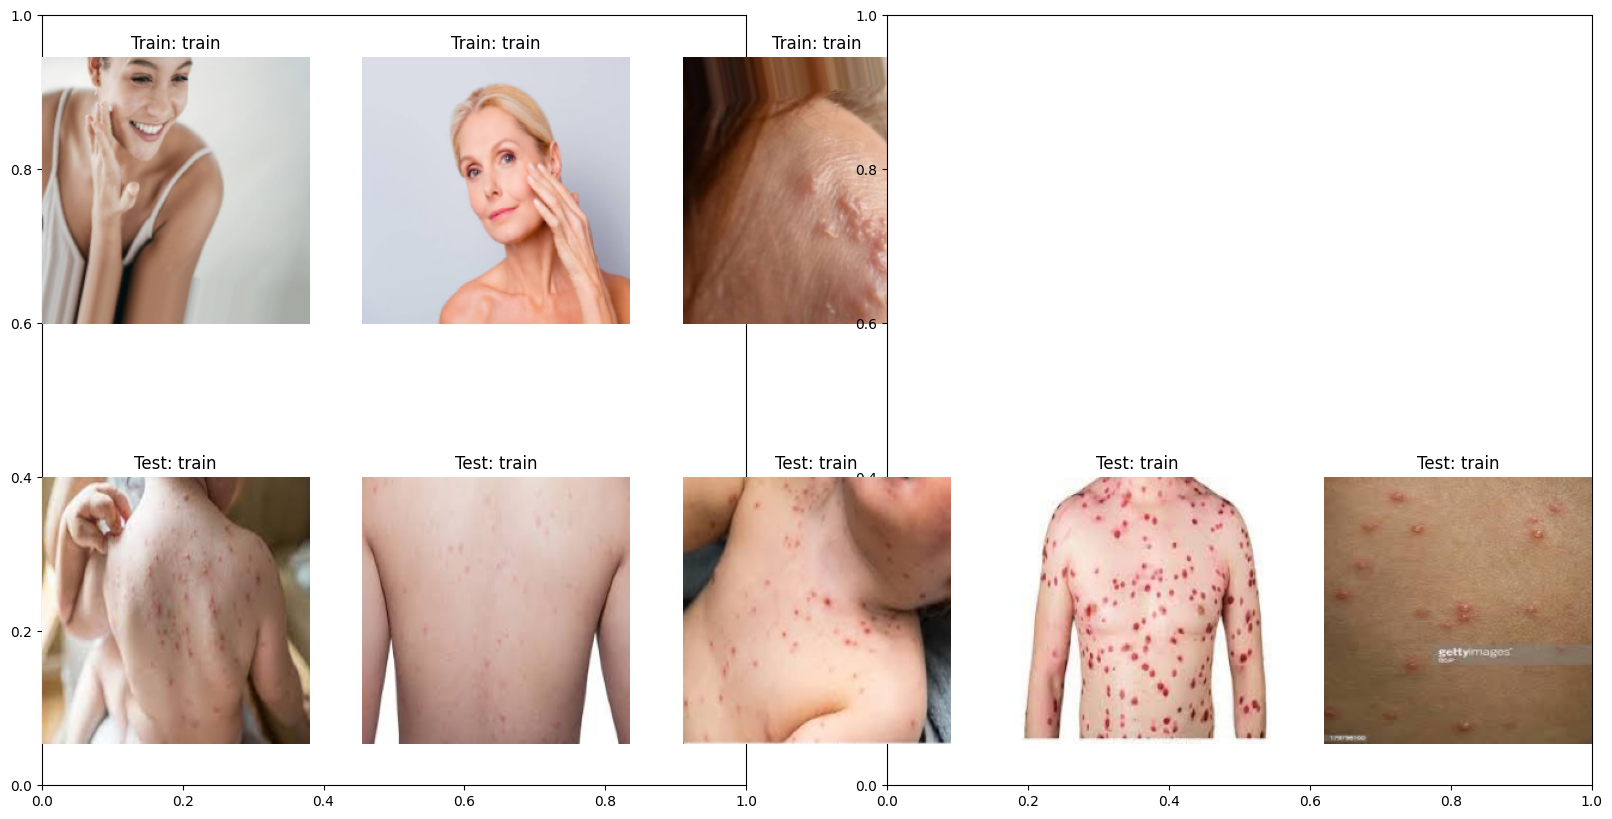


--- Class Distribution ---

Training Dataset:
train: 552 images

Validation Dataset:
train: 137 images

Test Dataset:
test: 81 images


<Figure size 2000x500 with 0 Axes>

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored

18/18 ━━━━━━━━━━━━━━━━━━━━ 151s 8s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 184s 7s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 132s 7s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 135s 7s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 125s 7s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 2.0000e-05
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 142s 8s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 2.0000e-05
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━

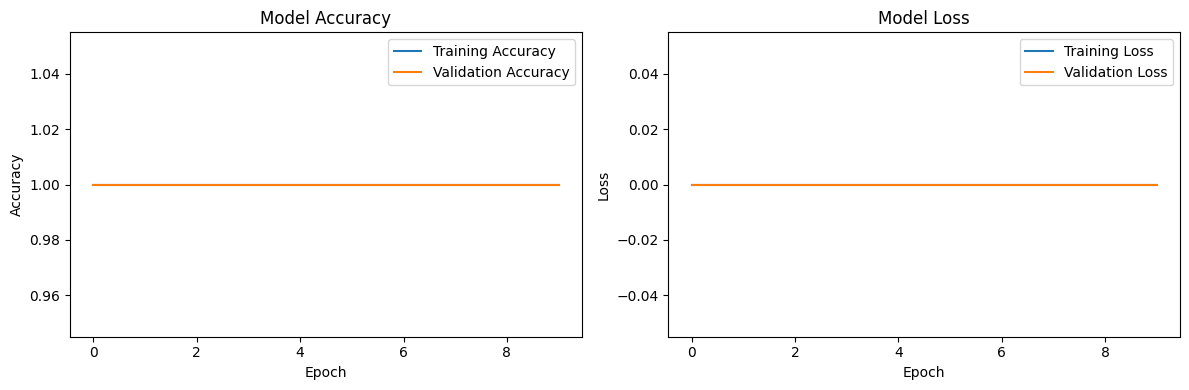

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step


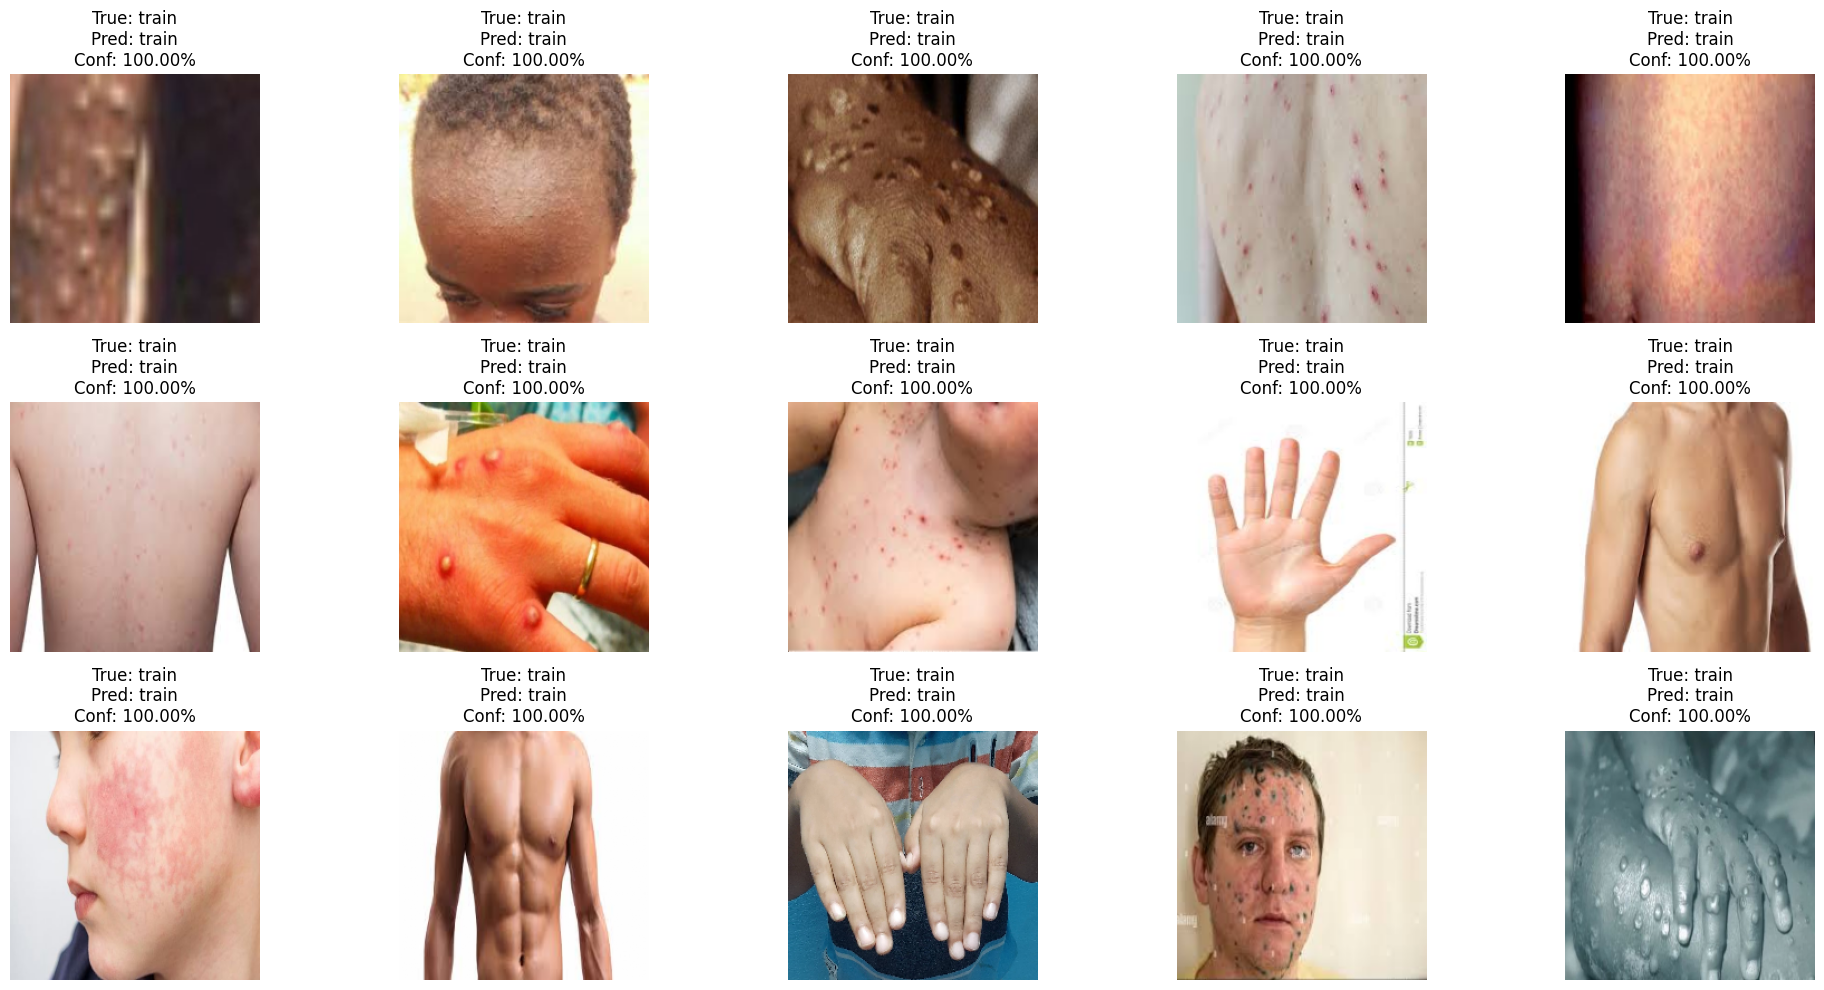

3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step

--- Classification Report ---
              precision    recall  f1-score   support

       train       1.00      1.00      1.00        81

    accuracy                           1.00        81
   macro avg       1.00      1.00      1.00        81
weighted avg       1.00      1.00      1.00        81


--- Detailed Performance Metrics ---
   Class  Precision  Recall  F1-Score  Support
0  train        1.0     1.0       1.0     81.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


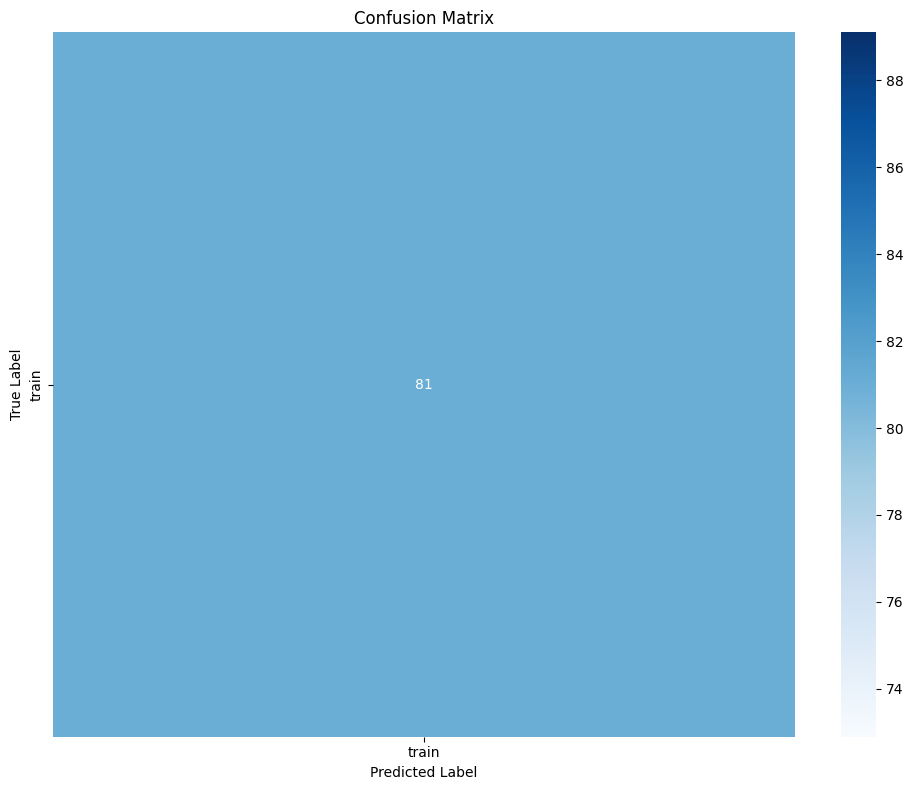

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


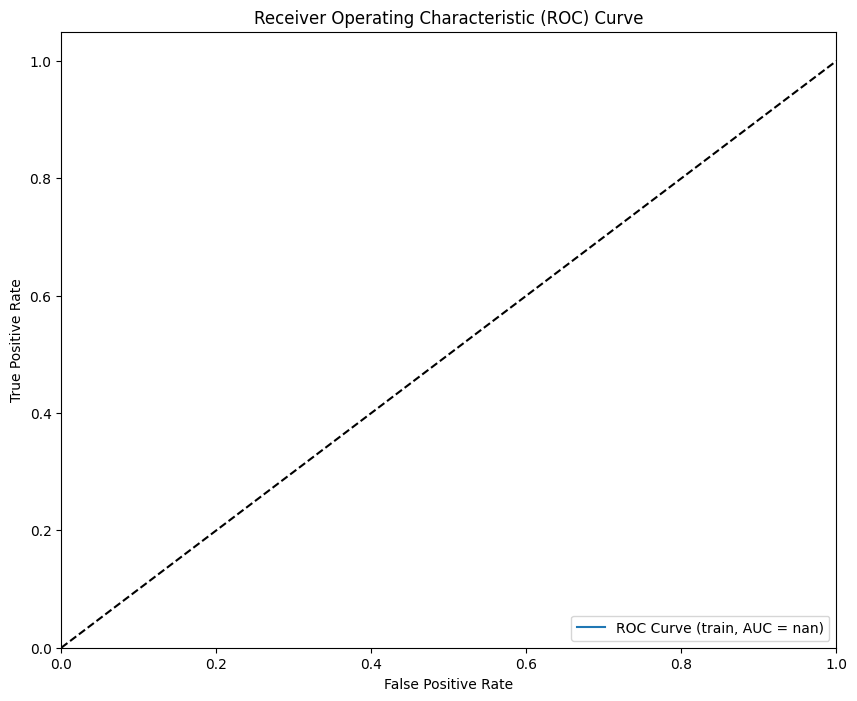

In [ ]:
# 3. CNN MODEL FOR MONKEYPOX PREDICTION
class MonkeypoxPredictor:
    def __init__(self, train_generator, validation_generator, test_generator):
        """
        Initialize monkeypox prediction model

        Args:
            train_generator: Training data generator
            validation_generator: Validation data generator
            test_generator: Test data generator
        """
        self.train_generator = train_generator
        self.validation_generator = validation_generator
        self.test_generator = test_generator

        self.model = None
        self.history = None
        self.class_names = list(train_generator.class_indices.keys())

    def create_model(self, img_height=224, img_width=224):
        """Create transfer learning CNN model using ResNet50V2"""
        num_classes = len(self.class_names)

        # Base model with pre-trained weights
        base_model = ResNet50V2(
            weights='imagenet',
            include_top=False,
            input_shape=(img_height, img_width, 3)
        )

        # Freeze base model layers
        base_model.trainable = False

        # Custom classification head
        self.model = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation='softmax')
        ])

        # Compile the model
        self.model.compile(
            optimizer=optimizers.Adam(learning_rate=1e-4),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        return self.model

    def train_model(self, epochs=10):
        """Train the model"""
        # Callbacks
        checkpoint = ModelCheckpoint(
            'best_model.keras',
            monitor='val_accuracy',
            save_best_only=True
        )
        lr_reducer = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-6
        )

        # Train model
        self.history = self.model.fit(
            self.train_generator,
            validation_data=self.validation_generator,
            epochs=epochs,
            callbacks=[checkpoint, lr_reducer]
        )

        # Plot training history
        self._plot_training_history()

    def _plot_training_history(self):
        """Plot accuracy and loss during training"""
        plt.figure(figsize=(12, 4))

        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def predict_and_visualize(self):
        """Predict on test data and visualize results"""
        # Predict on test data
        predictions = self.model.predict(self.test_generator)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = self.test_generator.classes

        # Visualize predictions
        plt.figure(figsize=(20, 10))

        # Select a subset of images to visualize
        num_samples = min(15, len(self.test_generator.filenames))
        indices = np.random.choice(len(self.test_generator.filenames), num_samples, replace=False)

        for i, idx in enumerate(indices):
            plt.subplot(3, 5, i+1)
            img = plt.imread(os.path.join(self.test_generator.directory, self.test_generator.filenames[idx]))
            plt.imshow(img)

            # Prediction and true label
            true_label = self.class_names[true_classes[idx]]
            pred_label = self.class_names[predicted_classes[idx]]
            confidence = predictions[idx][predicted_classes[idx]] * 100

            plt.title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}%")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

# 4. COMPREHENSIVE EVALUATION
def comprehensive_evaluation(predictor):
    """Perform comprehensive model evaluation"""
    # Reset test generator
    predictor.test_generator.reset()

    # Predictions
    predictions = predictor.model.predict(predictor.test_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = predictor.test_generator.classes
    class_labels = predictor.class_names

    # 1. Classification Report
    print("\n--- Classification Report ---")
    report = classification_report(
        true_classes,
        predicted_classes,
        target_names=class_labels,
        output_dict=True
    )
    print(classification_report(
        true_classes,
        predicted_classes,
        target_names=class_labels
    ))

    # 2. Detailed Performance Metrics DataFrame
    performance_data = {
        'Class': class_labels,
        'Precision': [report[cls]['precision'] for cls in class_labels],
        'Recall': [report[cls]['recall'] for cls in class_labels],
        'F1-Score': [report[cls]['f1-score'] for cls in class_labels],
        'Support': [report[cls]['support'] for cls in class_labels]
    }
    performance_df = pd.DataFrame(performance_data)
    print("\n--- Detailed Performance Metrics ---")
    print(performance_df)

    # 3. Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(true_classes, predicted_classes)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_labels,
        yticklabels=class_labels
    )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    # 4. ROC Curve and AUC
    plt.figure(figsize=(10, 8))
    # One-vs-Rest ROC Curve
    for i in range(len(class_labels)):
        y_true_binary = (true_classes == i).astype(int)
        y_scores = predictions[:, i]
        fpr, tpr, _ = roc_curve(y_true_binary, y_scores)
        roc_auc = auc(fpr, tpr)

        plt.plot(
            fpr, tpr,
            label=f'ROC Curve ({class_labels[i]}, AUC = {roc_auc:.2f})'
        )

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def main():
    # Paths to your zip files
    train_zip = '/content/train.zip'
    test_zip = '/content/test.zip'

    # 2. DATA PREPROCESSING
    preprocessor = DataPreprocessor(train_zip, test_zip)
    train_gen, val_gen, test_gen = preprocessor.prepare_data_generators()

    # Visualize dataset
    preprocessor.visualize_dataset()

    # 3. MODEL TRAINING AND PREDICTION
    predictor = MonkeypoxPredictor(train_gen, val_gen, test_gen)
    model = predictor.create_model()
    predictor.train_model(epochs=10)

    # Visualize predictions
    predictor.predict_and_visualize()

    # 4. COMPREHENSIVE EVALUATION
    comprehensive_evaluation(predictor)

if __name__ == '__main__':
    main()

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_single_image(predictor, image_path):
    """
    Melakukan prediksi untuk satu gambar.

    Args:
        predictor (MonkeypoxPredictor): Objek yang berisi model terlatih.
        image_path (str): Path ke gambar tunggal yang akan diuji.

    Returns:
        None: Hasil ditampilkan sebagai teks dan visualisasi.
    """
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))  # Ukuran gambar sesuai model
    img_array = img_to_array(img) / 255.0  # Normalisasi ke [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch

    # Make prediction
    predictions = predictor.model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    confidence = predictions[0][predicted_class] * 100
    class_name = predictor.class_names[predicted_class]

    # Display results
    print(f"Predicted Class: {class_name}")
    print(f"Confidence: {confidence:.2f}%")

    # Visualize the image with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Prediction: {class_name}\nConfidence: {confidence:.2f}%")
    plt.axis('off')
    plt.show()


Extracting training dataset...
Extracting test dataset...
Datasets extracted successfully.
Found 552 images belonging to 1 classes.
Found 137 images belonging to 1 classes.
Found 81 images belonging to 1 classes.


<ipython-input-2-c8901615028a>:119: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


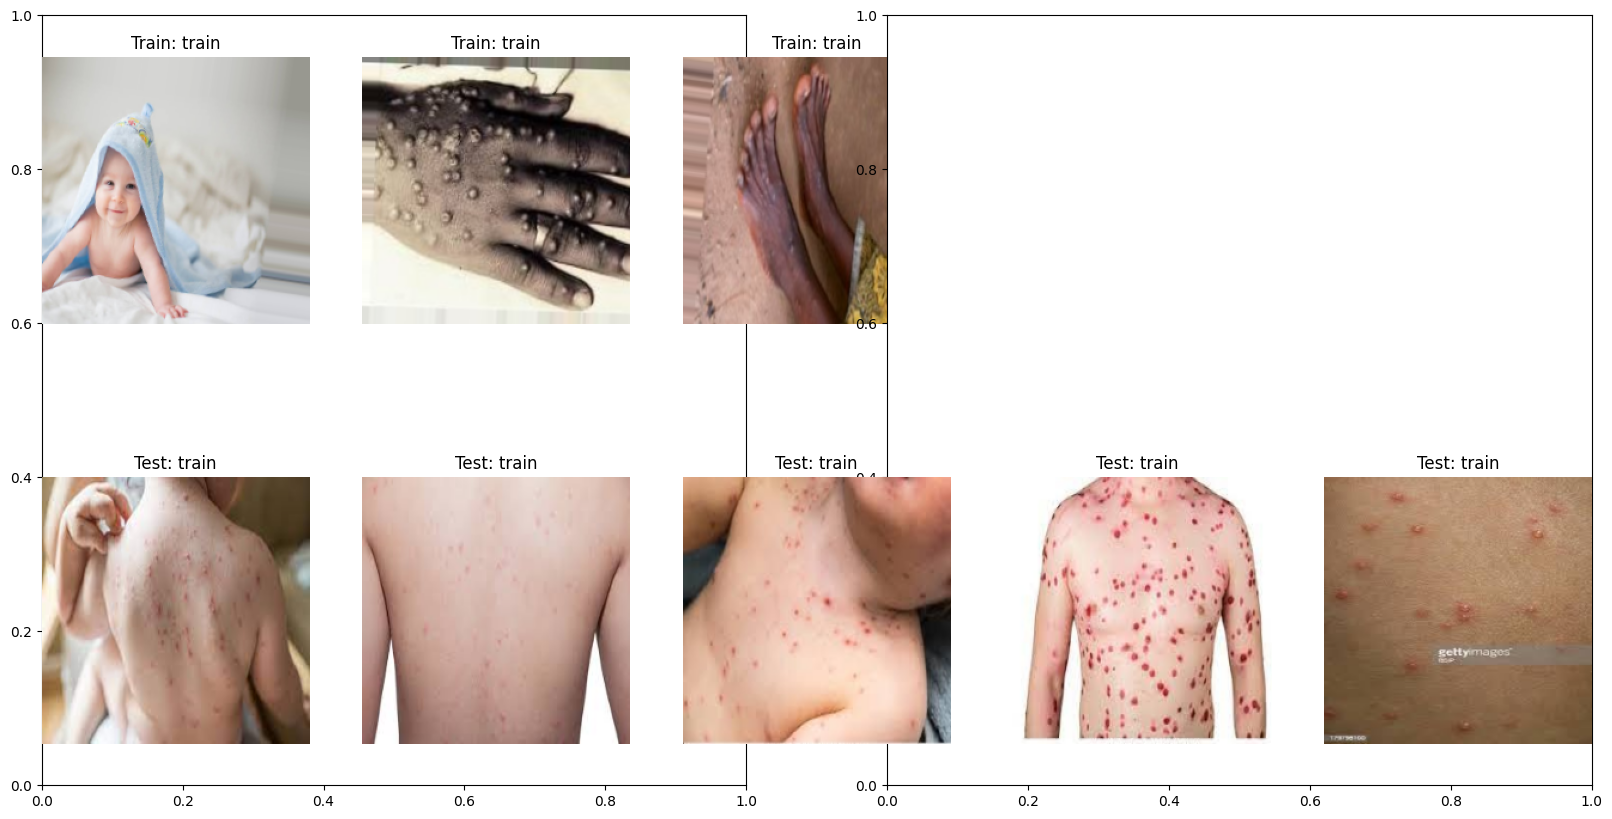


--- Class Distribution ---

Training Dataset:
train: 552 images

Validation Dataset:
train: 137 images

Test Dataset:
test: 81 images


<Figure size 2000x500 with 0 Axes>

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored

18/18 ━━━━━━━━━━━━━━━━━━━━ 138s 7s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 148s 8s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 178s 7s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 141s 7s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 144s 7s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 2.0000e-05
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 124s 7s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 2.0000e-05
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━

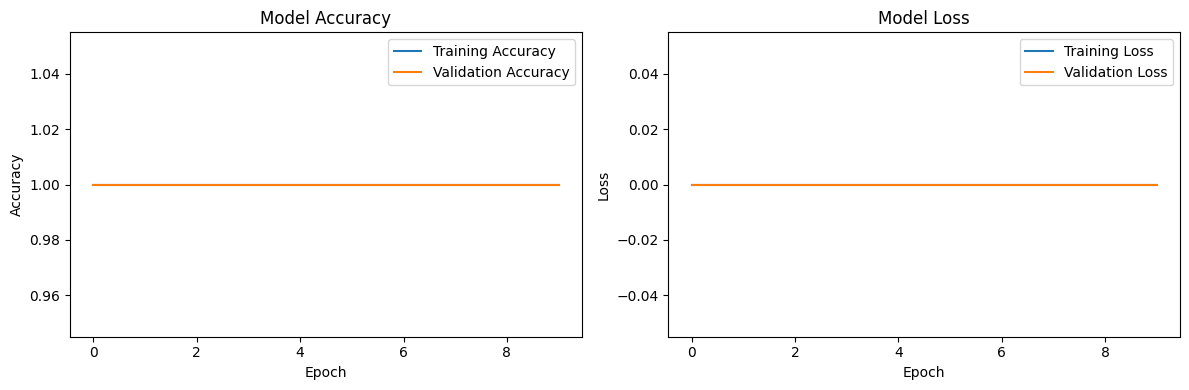

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/3 ━━━━━━━━━━━━━━━━━━━━ 5s 6s/step 

3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step


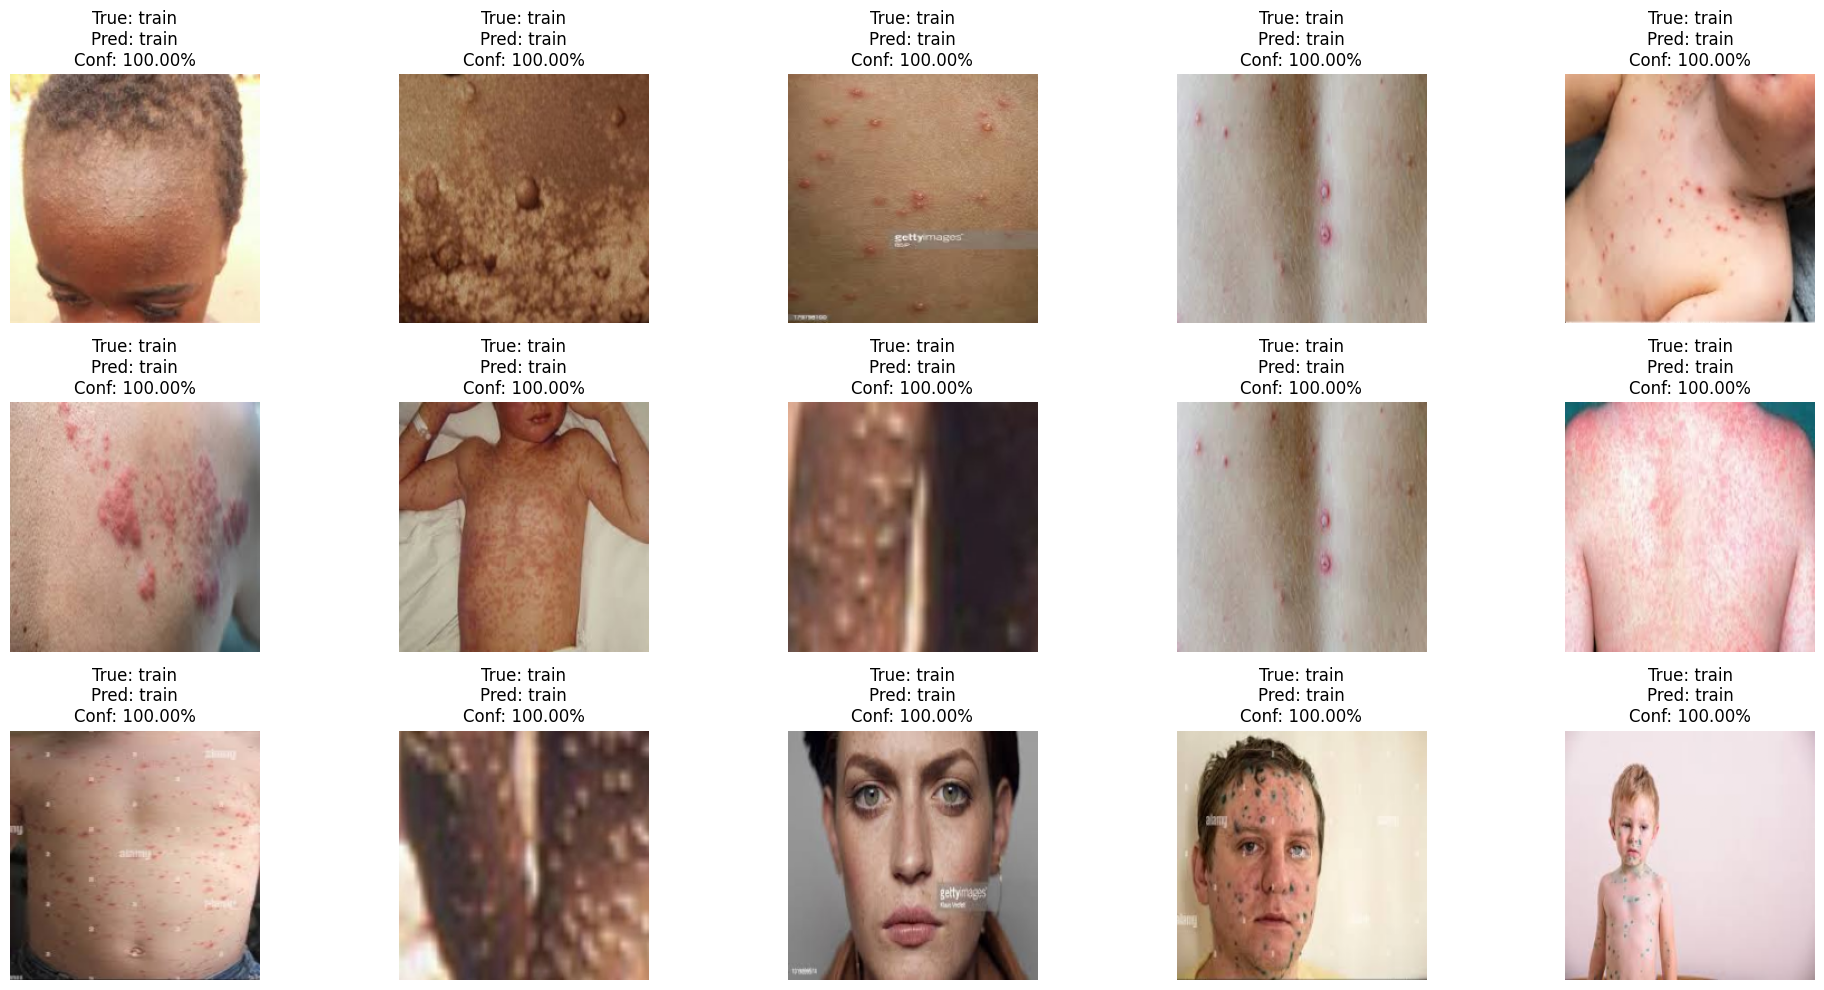

3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step

--- Classification Report ---
              precision    recall  f1-score   support

       train       1.00      1.00      1.00        81

    accuracy                           1.00        81
   macro avg       1.00      1.00      1.00        81
weighted avg       1.00      1.00      1.00        81


--- Detailed Performance Metrics ---
   Class  Precision  Recall  F1-Score  Support
0  train        1.0     1.0       1.0     81.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


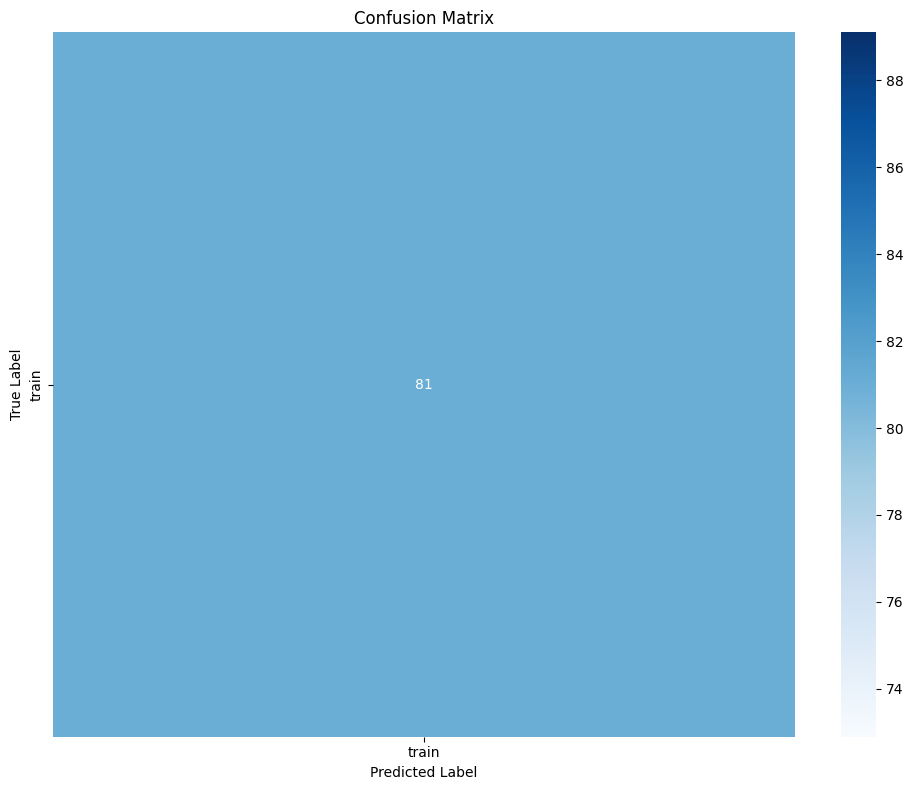

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


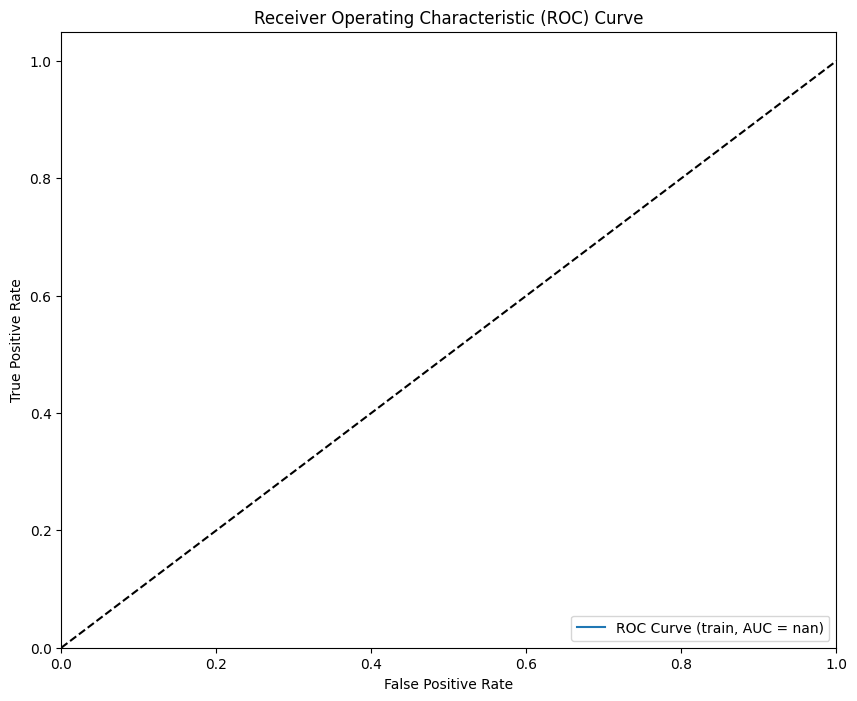

Extracting training dataset...
Extracting test dataset...
Datasets extracted successfully.
Found 552 images belonging to 1 classes.
Found 137 images belonging to 1 classes.
Found 81 images belonging to 1 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: train
Confidence: 100.00%


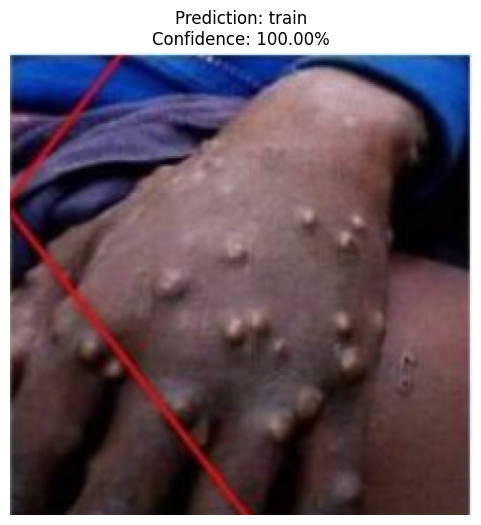

In [ ]:
if __name__ == '__main__':
    main()

    # Path ke gambar tunggal
    test_image_path = '/content/monkeypox4.png'

    # Load kembali model yang sudah dilatih
    preprocessor = DataPreprocessor('/content/train.zip', '/content/test.zip')
    train_gen, val_gen, test_gen = preprocessor.prepare_data_generators()
    predictor = MonkeypoxPredictor(train_gen, val_gen, test_gen)
    predictor.model = tf.keras.models.load_model('best_model.keras')

    # Prediksi gambar tunggal
    predict_single_image(predictor, test_image_path)
